# Step 1: INTRODUCTION
https://calebhyun.github.io/pickleball-point-analysis/

## Question: Can we predict the winner of an individual pickleball point based on numerical and categorical features of the particular point?

### Followup: Then can we utilize this prediction and analyze which features contribute the most towards which team won the pickleball point?

# Step 2: Data Cleaning and Exploratory Data Analysis

The **pklshop API** allowed us to get 2 main datasets. One was a dataset containing rallies indexed by game it occured in. The next was shots indexed by each rally.

Our goal was to combine these datasets into a final dataset of rallies indexed by game. But this dataset would now contain additional information that we got from the shots dataframe.

**The specific metrics we pulled are:** Serve and Return team Dink Count, Serve and Return team Speedup count, Serve and Return Team lob count,
and which team did a speedup first.

## Rallies Dataframe:

~ 2,500 rows, relevant columns include
`'srv_team_id',
       'ts_type', 'w_team_id', 'rally_len',
       'srv_switch_ind', 'rtrn_switch_ind', 'srv_team_flipped_ind',
       'rtrn_team_flipped_ind', 'ending_type', 'lob_cnt',
       'dink_cnt'`

      
## Shots Dataframe:
~ 22,800 rows, relevant columns include `'shot_type_orig', location.`



**50 games ~2,500 rallies, and ~22,000 shots.**


In [ ]:
!pip install pklshop

In [ ]:
from pklshop.data import *
from pklshop.stats import *
from pklshop.name import *
from pklshop.game import Game
from pklshop.match import *
from pklshop.rally import plot_court

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    roc_auc_score,
)
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display

### Data Cleaning

The pklshop API didn't allow us to pull the full rallies dataframe, so we had to append the rallies game by game into a final `combined_rallies` dataset.

Similarly, we accessed the shots, rally by rally, to create our final `combined_shots` dataset.

In [ ]:
all_rallies = []

# Loop through game IDs G1 to G58
for game_id in range(1, 59):  # G1 to G58
    #print(game_id)
    if game_id != 25 and game_id != 44 and game_id != 45 and game_id != 46:
        game_id_str = f"G{game_id}"  # Format game ID as "G1", "G2", ..., "G58"
        game = Game(game_id_str)  # Initialize Game object
        rally_df = game.rally  # Get the rally DataFrame for the current game
        #rally_df["game_id"] = game_id_str  # Add a column to keep track of the game ID
        all_rallies.append(rally_df)  # Append the DataFrame to the list

combined_rallies = pd.concat(all_rallies, ignore_index=True)

In [ ]:
combined_rallies.columns

Index(['rally_id', 'match_id', 'game_id', 'rally_nbr', 'srv_team_id',
       'srv_player_id', 'rtrn_team_id', 'rtrn_player_id', 'ts_player_id',
       'ts_type', 'w_team_id', 'to_ind', 'to_team_id', 'rally_len',
       'srv_switch_ind', 'rtrn_switch_ind', 'srv_team_flipped_ind',
       'rtrn_team_flipped_ind', 'ending_type', 'ending_player_id', 'lob_cnt',
       'dink_cnt', 'maint_dtm', 'maint_app', 'create_dtm', 'create_app'],
      dtype='object')

In [ ]:
all_shots = []

# Loop through each rally ID in the DataFrame
for rally_id in combined_rallies['rally_id'].unique():
    try:
        # Create a Rally instance for the current rally_id
        rally_instance = Rally(rally_id=rally_id)

        # Extract the shots DataFrame for this rally
        shots_df = rally_instance.shot

        # Add rally_id to the shots DataFrame for tracking
        shots_df['rally_id'] = rally_id

        all_shots.append(shots_df)
    except Exception as e:
      continue

combined_shots = pd.concat(all_shots, ignore_index=True)
combined_shots.head()

markdown_table = combined_shots.head().to_markdown(index=False)


print(markdown_table)

| shot_id   | rally_id   |   shot_nbr | shot_type_orig   | shot_type   | player_id   |   entry_ts |   btt_before |   btt_after |   loc_x |   loc_y |   next_loc_x |   next_loc_y |   cst_model_id |   whtb_model_id | maint_dtm                        | maint_app   | create_dtm                       | create_app   |
|:----------|:-----------|-----------:|:-----------------|:------------|:------------|-----------:|-------------:|------------:|--------:|--------:|-------------:|-------------:|---------------:|----------------:|:---------------------------------|:------------|:---------------------------------|:-------------|
| S467      | R47        |          1 | SE               | SE          | P4          |        nan |          nan |         nan |     nan |     nan |          nan |          nan |            nan |             nan | 2022-07-30 21:41:10.918407+00:00 | aspancak    | 2022-04-09 03:19:34.047765+00:00 | postgres     |
| S468      | R47        |          2 | R                | R 

In [ ]:
combined_shots[combined_shots['btt_before'].isna()].count()
combined_shots
combined_shots.columns

Index(['shot_id', 'rally_id', 'shot_nbr', 'shot_type_orig', 'shot_type',
       'player_id', 'entry_ts', 'btt_before', 'btt_after', 'loc_x', 'loc_y',
       'next_loc_x', 'next_loc_y', 'cst_model_id', 'whtb_model_id',
       'maint_dtm', 'maint_app', 'create_dtm', 'create_app'],
      dtype='object')

In [ ]:
scatter_fig = px.scatter(
    combined_rallies,
    x='rally_len',
    y='dink_cnt',
    title='Scatter Plot: Rally Length vs. Dink Count',
    labels={'rally_len': 'Rally Length', 'dink_cnt': 'Dink Count'},
    color='ending_type'
)
scatter_fig.show()

box_fig = px.box(
    combined_rallies,
    x='ending_type',
    y='rally_len',
    title='Box Plot: Rally Length by Ending Type',
    labels={'ending_type': 'Ending Type', 'rally_len': 'Rally Length'},
)
box_fig.show()
combined_rallies.columns

scatter_fig.write_html("rally_length_vs_dink_count.html", include_plotlyjs="cdn")

box_fig.write_html("rally_length_by_end_type.html", include_plotlyjs="cdn")

We analyzed the main ways points end with our Univariate Analysis #1 and Bivariate Analysis #1.

As expected, we saw a strong correlation between total rally length and the number of dinks hit. We can see through these graphs that errors tend to occur in the first 5-10 shots, but as the points get longer, winners tend to become more prevalent.

For pickleball players, during the first few shots you should be focusing on forcing errors out of your opponents, not necessarily hitting winners off of the serve, return, or 3-5 shots.

In [ ]:
rallies = combined_rallies[combined_rallies['ending_type'] != 'Unforced Error']


shots = combined_shots.merge(rallies, on='rally_id')

def assign_team_hit(group):
    # Create alternating pattern 'S', 'R' for the group
    group['team_hit'] = ['S' if i % 2 == 0 else 'R' for i in range(len(group))]
    return group

shots = shots.groupby('rally_id', group_keys=False).apply(assign_team_hit)
shots.head()

<ipython-input-38-8395aaedd35e>:11: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,shot_id,rally_id,shot_nbr,shot_type_orig,shot_type,player_id,entry_ts,btt_before,btt_after,loc_x,...,rtrn_team_flipped_ind,ending_type,ending_player_id,lob_cnt,dink_cnt,maint_dtm_y,maint_app_y,create_dtm_y,create_app_y,team_hit
0,S467,R47,1,SE,SE,P4,NaN,NaN,NaN,NaN,...,N,Other,NaN,0,2,2022-04-09 03:19:34.046771+00:00,postgres,2022-04-09 03:19:34.046771+00:00,postgres,S
1,S468,R47,2,R,R,P1,NaN,NaN,NaN,NaN,...,N,Other,NaN,0,2,2022-04-09 03:19:34.046771+00:00,postgres,2022-04-09 03:19:34.046771+00:00,postgres,R
2,S469,R47,3,tsDrp,tsDrp,P4,NaN,NaN,NaN,NaN,...,N,Other,NaN,0,2,2022-04-09 03:19:34.046771+00:00,postgres,2022-04-09 03:19:34.046771+00:00,postgres,S
3,S470,R47,4,D,D,NaN,NaN,NaN,NaN,NaN,...,N,Other,NaN,0,2,2022-04-09 03:19:34.046771+00:00,postgres,2022-04-09 03:19:34.046771+00:00,postgres,R
4,S471,R47,5,D,D,NaN,NaN,NaN,NaN,NaN,...,N,Other,NaN,0,2,2022-04-09 03:19:34.046771+00:00,postgres,2022-04-09 03:19:34.046771+00:00,postgres,S


In [ ]:
valid_shot_types = shots[~shots['shot_type_orig'].isin(['O', 'A', 'E', 'SP'])]['shot_type_orig'].unique()

def plot_shot_type(selected_shot_type):
    shot_subset = shots[shots['shot_type_orig'] == selected_shot_type]

    shot_count = len(shot_subset)
    avg_x = shot_subset['loc_x'].mean()
    avg_y = shot_subset['loc_y'].mean()

    plt.figure(figsize=(10, 6))
    sns.set_style("white")

    plot_court()

    sns.kdeplot(
        x=shot_subset['loc_x'],
        y=shot_subset['loc_y'],
        shade=True,
        cmap="Blues",
        alpha=0.6
    )

    plt.title(f"Heatmap of {selected_shot_type} Shots on a Pickleball Court\n"
              f"Shot Count: {shot_count} | Average Location: ({avg_x:.2f}, {avg_y:.2f})")
    plt.xlabel("Court Width (x)")
    plt.ylabel("Court Depth (y)")
    plt.show()

shot_type_dropdown = widgets.Dropdown(
    options=valid_shot_types,
    description='Shot Type:'
)

interact(plot_shot_type, selected_shot_type=shot_type_dropdown)

NameError: name 'shots' is not defined

Bivariate Analysis #2:
Using pklshop's plot_court method, we were able to visualize where certain types of shots were hit.

Something interesting that we noticed was that third shot drops were generally hit when the return was hit deeper and more towards the middle, whereas third shot drives were generally hit off of shallower returns on the edges.This has implications for our model later!


In [ ]:
value_counts = shots['shot_type_orig'].value_counts().reset_index()
value_counts.columns = ['shot_type_orig', 'count']

fig = px.bar(value_counts, x='shot_type_orig', y='count',
             title='Shot Type Distribution',
             labels={'shot_type_orig': 'Shot Type', 'count': 'Frequency'},
             text='count')

fig.update_traces(texttemplate='%{text}', textposition='outside')

fig.show()

fig.write_html("shot_type_distribution.html", include_plotlyjs="cdn")

Univariate Analysis #2:
We found that the number one shot that was in pro matches was 'Other' (likely labelling error / inconsistency), followed by Dinks, with a relatively big drop off to Serves, Returns, Third-shot Drops, Third-shot Drives, Speedups, Lobs, Ernies, Third-shot Lobs, and ATPs.

## Creating our Final Dataframe to Do Analysis

In [ ]:
data = shots

def process_rally(group):
    serve_dink_count = group[(group['shot_type_orig'] == 'D') & (group['team_hit'] == 'S')].shape[0]

    return_dink_count = group[(group['shot_type_orig'] == 'D') & (group['team_hit'] == 'R')].shape[0]

    speedup_count_S = group[(group['shot_type_orig'] == 'SP') & (group['team_hit'] == 'S')].shape[0]
    speedup_count_R = group[(group['shot_type_orig'] == 'SP') & (group['team_hit'] == 'R')].shape[0]

    lob_count_S = group[(group['shot_type_orig'] == 'L') & (group['team_hit'] == 'S')].shape[0]
    lob_count_R = group[(group['shot_type_orig'] == 'L') & (group['team_hit'] == 'R')].shape[0]

    first_speedup = group[group['shot_type_orig'] == 'SP']
    first_to_speedup = first_speedup.iloc[0]['team_hit'] if not first_speedup.empty else None

    return pd.Series({
        'serve_dink_count': serve_dink_count,
        'return_dink_count': return_dink_count,
        'speedup_count_S': speedup_count_S,
        'speedup_count_R': speedup_count_R,
        'lob_count_S': lob_count_S,
        'lob_count_R': lob_count_R,
        'first_to_speedup': first_to_speedup
    })

rally_metrics = data.groupby('rally_id').apply(process_rally).reset_index()

columns_to_keep = [
    'w_team_id', 'srv_team_id', 'rally_id', 'ts_type', 'srv_switch_ind', 'rtrn_switch_ind',
    'srv_team_flipped_ind', 'rtrn_team_flipped_ind', 'rally_len'
]


final = data[columns_to_keep].drop_duplicates()
final = final.merge(rally_metrics, on='rally_id', how='left')
final['srv_team_won'] = (final['w_team_id'] == final['srv_team_id'])
final['first_to_speedup'] = final['first_to_speedup'].astype(str).fillna('NaN')
final.to_csv('final.csv')
final.head()


print(final.head().to_markdown(index=False))

| w_team_id   | srv_team_id   | rally_id   | ts_type   | srv_switch_ind   | rtrn_switch_ind   | srv_team_flipped_ind   | rtrn_team_flipped_ind   |   rally_len |   serve_dink_count |   return_dink_count |   speedup_count_S |   speedup_count_R |   lob_count_S |   lob_count_R | first_to_speedup   | srv_team_won   |
|:------------|:--------------|:-----------|:----------|:-----------------|:------------------|:-----------------------|:------------------------|------------:|-------------------:|--------------------:|------------------:|------------------:|--------------:|--------------:|:-------------------|:---------------|
| T1          | T2            | R47        | Drop      | N                | N                 | Y                      | N                       |           7 |                  1 |                   1 |                 0 |                 1 |             0 |             0 | R                  | False          |
| T1          | T1            | R49        | Drop      | Y

<ipython-input-41-d2d88cd18ba3>:27: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In order to create our model, we wanted to break down the number of shots hit by each team, as we originally only had the number of a shot hit during the point.

We created a final analysis dataframe, where along with other columns from the original dataframe, we used the shots dataframe to count the number of dinks, speedups, and lobs that each team hit, along with who was first to speedup.

We did not have to impute any values, as there were no missing values in the original dataframe.

<ipython-input-42-9330b925ad57>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




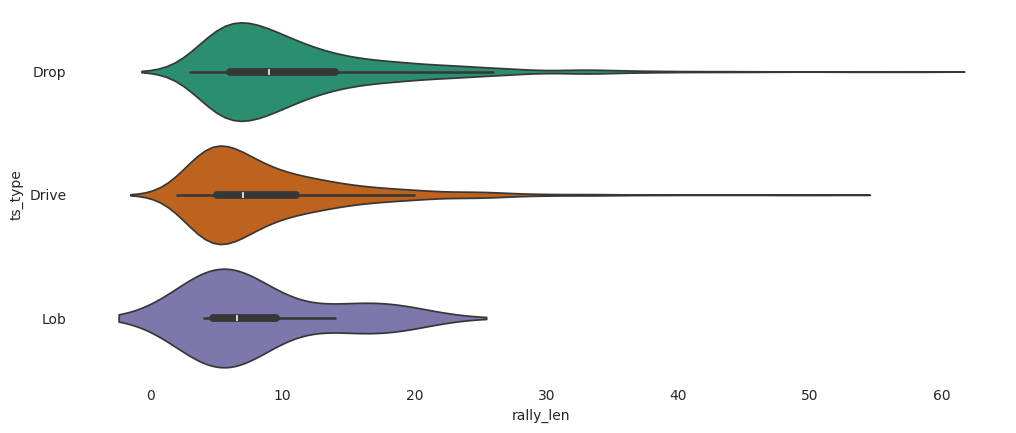

In [ ]:
# @title ts_type vs rally_len

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(final['ts_type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(final, x='rally_len', y='ts_type', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)


We visualized the length of rallies based on the third shot type, and found that the mean length of rally was lowest when the third shot was a lob, higher when the third shot was a drive, and highest when the third shot was a drop.

## Framing a Prediction Problem

We are solving a binary classification problem, trying to predict whether the serve team wins the rally. As pickleball players, we wanted to know what the most important factors were in our shot selection to win more points.

We selected features that a) we would know at the time a rally finished, and b) that compared the types of shots hit with the team hitting them.

We primarily evaluated our model using accuracy, as it was the most straightforward way to determine how often the model predicted the correct rally outcome.


## Baseline Model

In [ ]:
X = final[['rally_len', 'serve_dink_count', 'ts_type']]
y = final['srv_team_won']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Preprocessing
numerical_features = ['rally_len', 'serve_dink_count']
categorical_features = ['ts_type']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Train the pipeline
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
labels = [str(label) for label in pipeline.classes_]

text_annotations = [[f"{val}" for val in row] for row in cm]

fig = ff.create_annotated_heatmap(
    z=cm,
    x=labels,  # Predicted labels
    y=labels,  # True labels
    annotation_text=text_annotations,
    colorscale="Blues",
    showscale=True
)

fig.update_layout(
    title="Confusion Matrix",
    xaxis=dict(title="Predicted Label", side="top"),
    yaxis=dict(title="True Label"),
    margin=dict(l=40, r=40, t=40, b=40),
    font=dict(size=12)
)

html_file = "baseline_confusion_matrix.html"
fig.write_html(html_file, include_plotlyjs='cdn')

fig

Classification Report:
               precision    recall  f1-score   support

       False       0.61      0.93      0.74       316
        True       0.46      0.09      0.15       208

    accuracy                           0.60       524
   macro avg       0.53      0.51      0.44       524
weighted avg       0.55      0.60      0.50       524



## Baseline Model:
**Features:**
The baseline model uses rally length, serve team dink count (quantitative), and third shot type (nominal).

**Data Transformations:**

Numerical: rally_len and serve_dink_count are scaled with StandardScaler to ensure consistent feature scaling.
Categorical: ts_type is one-hot encoded with handle_unknown='ignore', enabling binary representation and handling unseen categories.

**Modeling Steps:**

Train-Test Split: The dataset is split to ensure unbiased performance evaluation on unseen data.
Pipeline: A ColumnTransformer scales numerical features and encodes categorical ones, feeding transformed data to a LogisticRegression model. The same transformations are applied to the test set during prediction.

**Evaluation:**

Performance is assessed using a classification report (precision, recall, F1-score) and a confusion matrix.


In [ ]:
final.columns

Index(['w_team_id', 'srv_team_id', 'rally_id', 'ts_type', 'srv_switch_ind',
       'rtrn_switch_ind', 'srv_team_flipped_ind', 'rtrn_team_flipped_ind',
       'rally_len', 'serve_dink_count', 'return_dink_count', 'speedup_count_S',
       'speedup_count_R', 'lob_count_S', 'lob_count_R', 'first_to_speedup',
       'srv_team_won'],
      dtype='object')

## Final Model

In [ ]:


X = final[['serve_dink_count', 'return_dink_count', 'speedup_count_S', 'speedup_count_R', 'lob_count_S', 'lob_count_R', 'ts_type', 'srv_switch_ind', 'rtrn_switch_ind', 'srv_team_flipped_ind', 'rtrn_team_flipped_ind', 'first_to_speedup']]
y = final['srv_team_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

def feature_engineering(df):
    df['srv_switch_ind_bin'] = (df['srv_switch_ind'] == 'Y').astype(int)
    return df

X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

numerical_features = ['serve_dink_count', 'return_dink_count', 'speedup_count_S', 'speedup_count_R', 'lob_count_S', 'lob_count_R']
categorical_features = ['ts_type', 'srv_switch_ind', 'rtrn_switch_ind', 'srv_team_flipped_ind', 'rtrn_team_flipped_ind', 'first_to_speedup']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

y_pred = grid_search.best_estimator_.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
labels = [str(label) for label in grid_search.classes_]

text_annotations = [[f"{val}" for val in row] for row in cm]

fig = ff.create_annotated_heatmap(
    z=cm,
    x=labels,  # Predicted labels
    y=labels,  # True labels
    annotation_text=text_annotations,
    colorscale="Blues",
    showscale=True
)

fig.update_layout(
    title="Confusion Matrix - Final Model",
    xaxis=dict(title="Predicted Label", side="top"),
    yaxis=dict(title="True Label"),
    margin=dict(l=40, r=40, t=40, b=40)
)

fig.show()
html_file = "final_confusion_matrix.html"
fig.write_html(html_file, include_plotlyjs='cdn')

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Classification Report:
               precision    recall  f1-score   support

       False       0.67      0.80      0.73       316
        True       0.57      0.41      0.48       208

    accuracy                           0.65       524
   macro avg       0.62      0.61      0.61       524
weighted avg       0.63      0.65      0.63       524



Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
Best Cross-Validation Accuracy: 0.5949079959852793


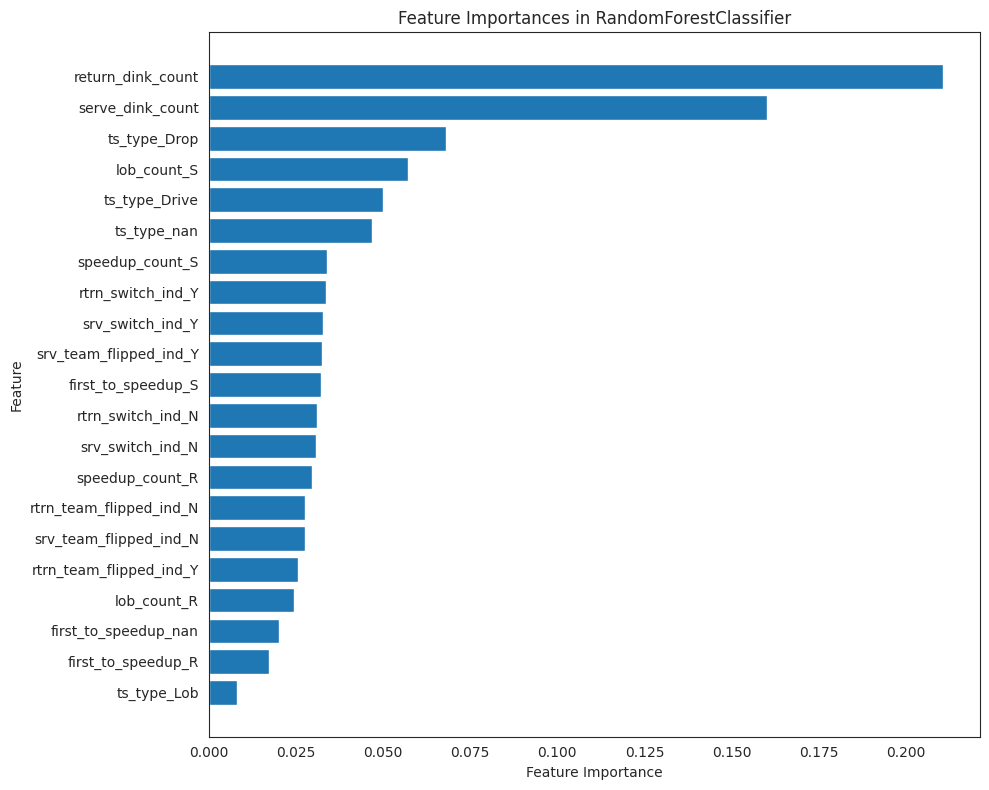

In [ ]:

best_rf = grid_search.best_estimator_.named_steps['classifier']
feature_names = (numerical_features +
                 list(grid_search.best_estimator_.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .get_feature_names_out(categorical_features)))

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]

plt.figure(figsize=(10, 8))
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), sorted_feature_names)
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importances in RandomForestClassifier")
plt.tight_layout()
plt.show()

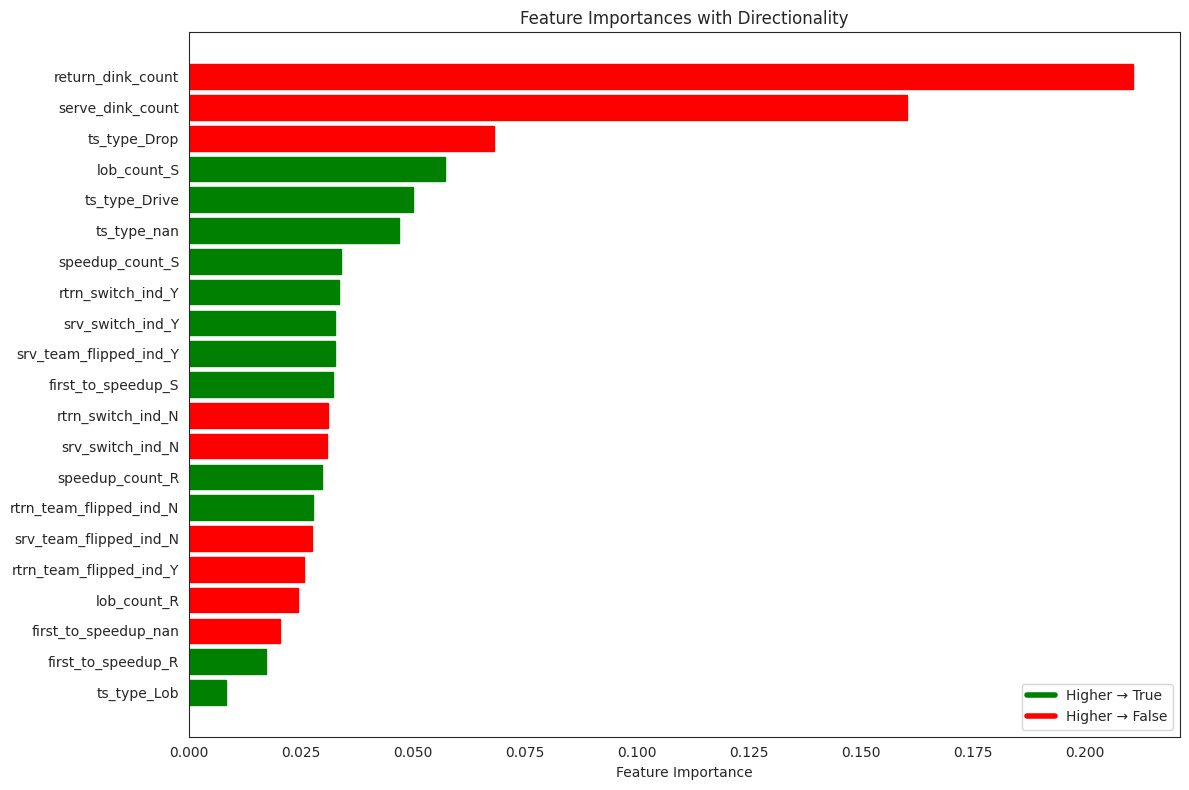

In [ ]:
rf_model = grid_search.best_estimator_.named_steps['classifier']

preprocessor = grid_search.best_estimator_.named_steps['preprocessor']
X_train_transformed = preprocessor.transform(X_train)

feature_names = (
    numerical_features +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
)

importances = rf_model.feature_importances_

X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names)
y_train_series = pd.Series(y_train)

class_means = X_train_transformed.groupby(y_train_series).mean()
direction = class_means.loc[True] - class_means.loc[False]

indices = np.argsort(importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importances = importances[indices]
sorted_directions = direction.iloc[indices]

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importances with Directionality')
plt.gca().invert_yaxis()

for bar, dir_value in zip(bars, sorted_directions):
    color = 'green' if dir_value > 0 else 'red'
    bar.set_color(color)

plt.legend(
    handles=[
        plt.Line2D([0], [0], color='green', lw=4, label='Higher → True'),
        plt.Line2D([0], [0], color='red', lw=4, label='Higher → False')],
    loc='lower right'
)

plt.tight_layout()
plt.show()


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Classification Report:
               precision    recall  f1-score   support

       False       0.68      0.72      0.70       316
        True       0.53      0.48      0.51       208

    accuracy                           0.63       524
   macro avg       0.61      0.60      0.60       524
weighted avg       0.62      0.63      0.62       524



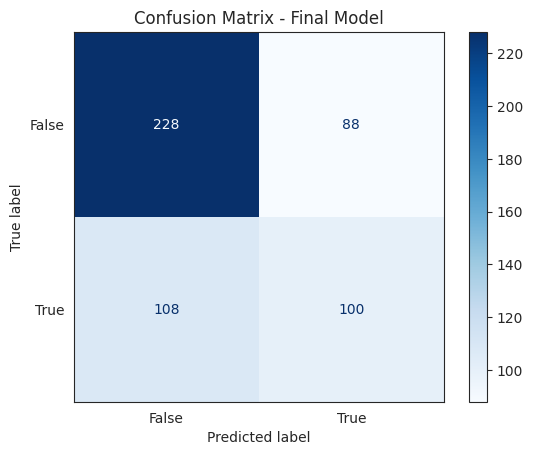

Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Best Cross-Validation Accuracy: 0.6211073937771829
Classification Report (Adjusted Threshold):
               precision    recall  f1-score   support

       False       0.69      0.70      0.70       316
        True       0.54      0.53      0.53       208

    accuracy                           0.63       524
   macro avg       0.62      0.61      0.62       524
weighted avg       0.63      0.63      0.63       524



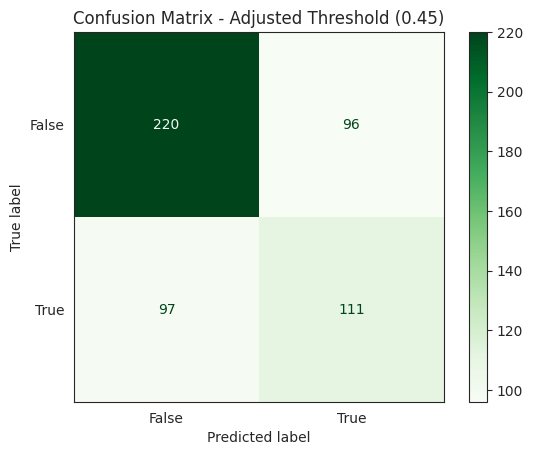

In [ ]:
X = final[['rally_len', 'serve_dink_count', 'return_dink_count', 'speedup_count_S', 'speedup_count_R', 'lob_count_S', 'lob_count_R', 'ts_type', 'srv_switch_ind', 'rtrn_switch_ind', 'srv_team_flipped_ind', 'rtrn_team_flipped_ind', 'first_to_speedup']]
y = final['srv_team_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature Engineering
def classify_rally_len(length):
    if length < 6.0:
      return 'short'
    elif length < 12.0:
      return 'medium'
    else:
      return 'long'
# Feature Engineering
def feature_engineering(df):
    df['srv_switch_ind_bin'] = (df['srv_switch_ind'] == 'Y').astype(int)
    df['rally_len_categorical'] = df['rally_len'].apply(classify_rally_len)
    df['dink_count_dif'] = df['serve_dink_count'] - df['return_dink_count']
    df['speedup_count_dif'] = df['speedup_count_S'] - df['speedup_count_R']
    df['lob_count_dif'] = df['lob_count_S'] - df['lob_count_R']
    return df

X_train_raw = feature_engineering(X_train.copy())
X_test_raw = feature_engineering(X_test.copy())

X_train = X_train_raw.copy()
X_test = X_test_raw.copy()


numerical_features = ['dink_count_dif', 'speedup_count_dif', 'lob_count_dif']
categorical_features = ['rally_len_categorical', 'ts_type', 'srv_switch_ind', 'rtrn_switch_ind', 'srv_team_flipped_ind', 'rtrn_team_flipped_ind', 'first_to_speedup']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

y_pred = grid_search.best_estimator_.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred, labels=grid_search.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Final Model")
plt.show()

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

y_probs = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

threshold = 0.45
y_pred_thresholded = (y_probs >= threshold).astype(int)

print("Classification Report (Adjusted Threshold):\n", classification_report(y_test, y_pred_thresholded))

cm_thresholded = confusion_matrix(y_test, y_pred_thresholded, labels=grid_search.classes_)
disp_thresholded = ConfusionMatrixDisplay(confusion_matrix=cm_thresholded, display_labels=grid_search.classes_)
disp_thresholded.plot(cmap=plt.cm.Greens)
plt.title(f"Confusion Matrix - Adjusted Threshold ({threshold})")
plt.show()


# Final Model: Random Forest Classifier

For the final model, we used a **Random Forest Classifier** and improved upon the baseline model by engineering new features and tuning hyperparameters using **GridSearchCV**.

## **Feature Engineering**
1. **Interaction Features**
   - **`dink_count_dif`:** Difference between serve and return dink counts. This captures the net dominance in dinks.
   - **`speedup_count_dif`:** Difference between serve and return speedups. This reflects aggression levels in rallies.
   - **`lob_count_dif`:** Difference between serve and return teams lobs.

2. **Categorical Transformation**
   - **`rally_len_categorical`:** Converted `rally_len` into short, medium, and long categories.
   - Binary encoding for features like `srv_switch_ind`.

## **Modeling Algorithm**
- **Random Forest Classifier**: We chose the random forest model because it inherently models the complex, non-linear features better than a logistic regression model. It can also capture interactions between the features better than logistic regression.
- **Hyperparameter Tuning**:
  - **`n_estimators`:** Number of trees in the forest. Tuning this controls the trade-off between model accuracy and training time, as more trees typically improve performance up to a point.
  - **`max_depth`:** Controls tree depth to prevent overfitting. Tuning this ensures that trees are not too deep (overfitting) or too shallow (underfitting), balancing model complexity.
  - **`classifier_min_samples_split`:** Controls the minimum number of samples to split a node in a decision tree. Tuning this prevents overly complex trees by ensuring splits occur only when enough data supports them.

## **Performance Evaluation**
- **Test Set Results**:
  - **Classification Report**: Our final model shows improved precision, recall, and F1-scores compared to the baseline model.
  - **Confusion Matrix**: Our final model had better differentiation between classes, particularly reducing false negatives.



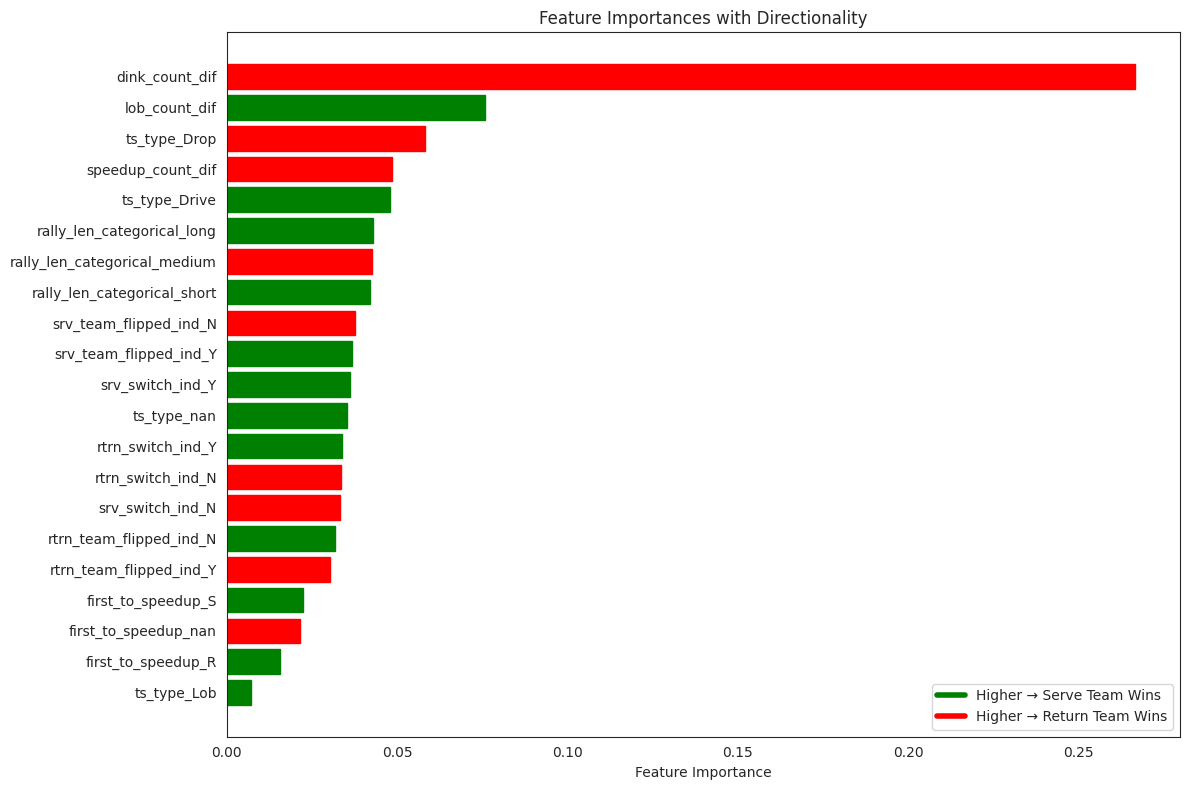

In [ ]:
rf_model = grid_search.best_estimator_.named_steps['classifier']

preprocessor = grid_search.best_estimator_.named_steps['preprocessor']
X_train_transformed = preprocessor.transform(X_train)

feature_names = (
    numerical_features +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
)

importances = rf_model.feature_importances_

X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names)
y_train_series = pd.Series(y_train)

class_means = X_train_transformed.groupby(y_train_series).mean()
direction = class_means.loc[True] - class_means.loc[False]

indices = np.argsort(importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importances = importances[indices]
sorted_directions = direction.iloc[indices]
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importances with Directionality')
plt.gca().invert_yaxis()

for bar, dir_value in zip(bars, sorted_directions):
    color = 'green' if dir_value > 0 else 'red'
    bar.set_color(color)

# Add legend
plt.legend(
    handles=[
        plt.Line2D([0], [0], color='green', lw=4, label='Higher → Serve Team Wins'),
        plt.Line2D([0], [0], color='red', lw=4, label='Higher → Return Team Wins')],
    loc='lower right'
)

plt.tight_layout()
plt.show()


## Hyperparameter Performance
`dink_count_dif` was the most used hyperparameter by far - this means that the more the serving team dinks more than the serving team, the more likely the returning team is to win the point.

`ts_drop` and `ts_drive` were also important (one hot encoded from `ts_type`), however when teams drop on the third shot, our model predicted them to lose the point, whereas when they drove our model predicted them more likely to win.

`rally_len_categorical` was also somewhat important: when the rally length was short, the serve team was more likely to win (likely mainly off of return errors), when the length was medium, the return team was more likely to win, and when the length was long, the serve team regained their advantage.

`

In [ ]:
pipeline.fit(X_train, y_train)

feature_names = numerical_features + categorical_features  # Use original categorical feature names

X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)
X_test_transformed_df = pd.DataFrame(
    X_test_transformed,
    columns=numerical_features + list(
        pipeline.named_steps['preprocessor']
        .named_transformers_['cat']
        .get_feature_names_out(categorical_features)
    )
)

X_test_transformed_df['predicted_proba'] = y_probs


def plot_feature(feature):
    if feature in numerical_features:
        X_test_transformed_df[f'{feature}_bucket'] = pd.cut(
          X_test_transformed_df[feature],
          bins=[-float('inf'), -.99, .99, float('inf')],
          labels=['<0', '0', '>0']
      )

        mean_proba_by_value = X_test_transformed_df.groupby(f'{feature}_bucket')['predicted_proba'].mean()
        mean_proba_by_value.plot(kind='bar', color='orange', legend=False)
        plt.title(f"Influence of '{feature}' on Prediction")
        plt.ylabel("Average Predicted Probability of 'srv_team_won' = True")
        plt.xlabel(f"'{feature}' Value (Buckets)")
    else:
        feature_indices = [
            i for i, name in enumerate(X_test_transformed_df.columns) if feature in name
        ]
        mean_proba_by_value = {}
        for idx in feature_indices:
            category_indices = X_test_transformed_df.iloc[:, idx] == 1
            mean_proba_by_value[X_test_transformed_df.columns[idx]] = X_test_transformed_df.loc[
                category_indices, 'predicted_proba'
            ].mean()

        mean_proba_by_value = pd.DataFrame(
            list(mean_proba_by_value.items()), columns=['Category', 'Mean Probability']
        )
        mean_proba_by_value.set_index('Category').plot(kind='bar', color='orange', legend=False)
        plt.title(f"Influence of '{feature}' on Prediction")
        plt.ylabel("Average Predicted Probability of 'srv_team_won' = True")
        plt.xlabel(f"'{feature}' Value (Categories)")

    plt.tight_layout()
    plt.show()


feature_dropdown = widgets.Dropdown(
    options=feature_names,
    description='Feature:',
    value=feature_names[0]
)

interactive_plot = interact(plot_feature, feature=feature_dropdown)
display(interactive_plot)


interactive(children=(Dropdown(description='Feature:', options=('dink_count_dif', 'speedup_count_dif', 'lob_co…

<function __main__.plot_feature(feature)>

## Interesting Insights:

Qualifiers - Our model is not perfect by any means, and this was trained on pro matches, so the takeaways may be different than amateur matches.

**Influence of `ts_type`:**
The model predicts a higher probability of the serving team winning when the shot type is 'Drive' compared to 'Drop' or 'Lob.' However, this reflects a correlation observed in the data and does not necessarily imply causation. For example, we saw that drives are generally hit off of shallower returns. Lobs seem to be the least effective third shot.

NaN being high in this graph makes sense, as when a third shot is not hit, it was likely off of an error in the return.

**Influence of `First to Speed Up`:**
Interestingly, the team to speed up first is strongly predicted to win the point, according to our model.

**Influence of `rally_len_categorical`:**
Something that surprised us was that the length of the category didn't seem to affect the prediction that much. We expected that, since the serving team has a small disadvantage going into the point (.45%), as the point goes on that disadvantage would go away when both teams get to the kitchen line. This was what we saw.

**Stacking:**
None of the stacking variables (srv, rtrn switch) seemed to make much of a difference on the model.


In [ ]:
numerical_features = ['dink_count_dif', 'speedup_count_dif', 'lob_count_dif']

categorical_features = ['rally_len_categorical', 'ts_type', 'srv_switch_ind',
                        'rtrn_switch_ind', 'srv_team_flipped_ind',
                        'rtrn_team_flipped_ind', 'first_to_speedup']

pipeline = grid_search.best_estimator_

X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

stored_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].feature_names_in_

feature_names = (
    numerical_features +
    list(pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(stored_feature_names))
)

X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)
X_test_transformed_df['predicted_proba'] = pipeline.predict_proba(X_test)[:, 1]

def plot_numeric_feature_with_bins(feature):
    if feature not in numerical_features:
        raise ValueError(f"{feature} not found in numerical features.")

    feature_data = X_test_raw[feature]

    bin_edges = [-np.inf, -0.1, 0.1, np.inf]
    bin_labels = ["Return Team Hit More", "Neither Team Hit More", "Serve Team Hit More"]

    bin_assignments = pd.cut(
        feature_data,
        bins=bin_edges,
        labels=bin_labels,
        right=False,
        include_lowest=True
    )

    bin_counts = bin_assignments.value_counts(sort=False)

    mean_proba_by_bin = X_test_transformed_df.groupby(bin_assignments)['predicted_proba'].mean()

    combined_data = mean_proba_by_bin.to_frame(name="Average Predicted Probability")
    combined_data["Count"] = bin_counts

    print(combined_data)

    mean_proba_by_bin.plot(kind='bar', color='orange', legend=False)
    plt.title(f"Influence of '{feature}' on Prediction (binned)")
    plt.ylabel("AvgPredicted Probability 'srv_team_won' = T      ")
    plt.xlabel(f"'{feature}' Bins (Original Scale)")
    plt.tight_layout()
    plt.show()

interactive_plot = widgets.interactive(plot_numeric_feature_with_bins, feature=numerical_features)
display(interactive_plot)


interactive(children=(Dropdown(description='feature', options=('dink_count_dif', 'speedup_count_dif', 'lob_cou…

## Conclusion
Pickleball point winners are inherently hard to predict, since it is a binary outcome clouded by hundreds of small choices. Our goal was to identify clear, actionable strategies that players can use to improve their chances of winning points by leveraging patterns and tendencies observed in gameplay.

### Strategy 1:
**Change your priorities as the point progresses.** As the returning team, prioritize aggression during the first six shots of the rally to force opponents into making an error. After this initial phase, and the serving team is at the kitchen line, shift gears between shots 6-12 to allow the rally to return to equilibrium. Once balance is restored, actively seek opportunities for decisive winners or unexpected speedups to catch your opponents off guard.

### Strategy 2:
**Don't feel forced to dink.** Our model predicted that the team that hit more dinks actually **lost** the point - mix in other types of shots and don’t let your opponents feel comfortable.

### Strategy 3:
**Don't be afraid to look for speedups.** Taking control of the rally by increasing the pace can break your opponents’ rhythm. Our model found that the first team to speed up generally won - however, pros normally speed up when they receive an attackable ball, so this metric may be correlation rather than causation.

### Strategy 4:
**Drive when you get a weak return.** Our model predicted that teams that drove on the third ball were more likely to win the point - however, based on the heatmap of where shots are hit, we can see that pros generally hit their drives when the return was more shallow, and dropped when the return was deep.

### Strategy 5:
**Stack away!**  Our model found that stacking does not have a significant impact on the winner of points. By stacking, you ensure that both partners are playing on their strongest side, which can improve shot quality and court coverage.
